In [1]:
from IPython.core.events import EventManager
from IPython import get_ipython
import time

global_start_time = None

def start_timer(event):
    global global_start_time
    global_start_time = time.time()

def stop_timer(event):
    global global_start_time
    if global_start_time:
        duration = time.time() - global_start_time
        print(f"Cell execution time: {duration:.3f} seconds")
        global_start_time = None

ip = get_ipython()
ip.events.register('pre_run_cell', start_timer)
ip.events.register('post_run_cell', stop_timer)

In [2]:
from skimage import io 
import pandas as pd 
import matplotlib.pyplot as plt
import gc
import numpy as np
from glob import glob 
import cv2
import matplotlib.colors as mcolors

Cell execution time: 1.161 seconds


In [3]:
red_denom = 2**13
blue_denom = 2**14
green_denom = 2**12
yellow_denom = 2**13

blue_adjust = 1.2
yellow_adjust = 1.1 
red_adjust = 1.8
green_adjust = 1.8

gamma = 1.4

Cell execution time: 0.000 seconds


In [4]:
red_mat = io.imread("../channel/PTB21.1_Red.tiff")
rawR = np.clip(red_mat /     red_denom,    0, 1)
imgR_norm = np.power(rawR, gamma) * red_adjust
imgR_final = np.clip(imgR_norm,                0, 1)
del red_mat
del rawR
del imgR_norm
gc.collect()

266

Cell execution time: 200.418 seconds


In [5]:
yellow_mat = io.imread("../channel/PTB21.1_Blue.tiff")
rawY = np.clip(yellow_mat / yellow_denom,    0, 1)
del yellow_mat

Cell execution time: 56.803 seconds


In [6]:
imgY_norm = np.power(rawY, gamma) * yellow_adjust
del rawY
gc.collect()

266

Cell execution time: 93.498 seconds


In [7]:
green_mat = io.imread("../channel/PTB21.1_Yellow.tiff") 

Cell execution time: 15.530 seconds


In [8]:
rawG = np.clip(green_mat /   green_denom,    0, 1)
imgG_norm = np.power(rawG, gamma) * green_adjust

del green_mat
del rawG
gc.collect()

266

Cell execution time: 135.163 seconds


In [9]:
imgG_final = np.clip(imgG_norm + imgY_norm,    0, 1)
del imgG_norm
gc.collect()

0

Cell execution time: 125.057 seconds


In [10]:
blue_mat = io.imread("../channel/PTB21.1_Green.tiff")

Cell execution time: 22.440 seconds


In [11]:
rawB = np.clip(blue_mat /    blue_denom,    0, 1)
imgB_norm = np.power(rawB, gamma) * blue_adjust
del blue_mat
del rawB
gc.collect()

266

Cell execution time: 122.725 seconds


In [12]:
imgB_final = np.clip(imgB_norm + imgY_norm,    0, 1)
del imgB_norm
del imgY_norm
gc.collect()

0

Cell execution time: 123.278 seconds


In [13]:
img = np.stack((imgR_final,imgG_final, imgB_final), -1)

Cell execution time: 332.810 seconds


In [14]:
del imgR_final
del imgG_final
del imgB_final

Cell execution time: 3.541 seconds


In [15]:
gc.collect()

0

Cell execution time: 0.287 seconds


In [16]:
# PTB 21.1 already has bounding boxes around each spot 
df = pd.read_excel("../data/geomx_211.xlsx",sheet_name="SegmentProperties")
df = df.loc[df["SlideName"]=="B172914-2"]
df = df[["ROILabel","ROICoordinateX","ROICoordinateY","AOISurfaceArea"]]

Cell execution time: 0.687 seconds


In [250]:
bb_fns = glob("../bb_mask/PTB211*")

Cell execution time: 0.003 seconds


In [251]:
img_path = "../bb_annot/PTB211_1.png"
tmp_img=plt.imread(img_path)
xw = np.floor(tmp_img.shape[1]/2).astype(int)

Cell execution time: 0.177 seconds


In [252]:
from scipy.sparse import lil_matrix
mask = lil_matrix(img.shape[:2], dtype=np.uint8)

Cell execution time: 0.811 seconds


In [253]:
font_dict = {i:(np.floor(xw/4).astype(int)-151,np.floor(xw/2).astype(int)) for i in df.ROILabel.values}

Cell execution time: 0.000 seconds


In [254]:
for bbf in bb_fns:
    # getting ROI and loading bounding box 
    roi=bbf.split("_")[-1].split(".npy")[0]
    roi=int(roi)
    if roi not in df["ROILabel"].values:
        continue

    # bounding box 
    bb_mat = np.load(bbf)

    # coordinates 
    ry,rx=df.loc[df["ROILabel"]==roi,["ROICoordinateX","ROICoordinateY"]].values[0]
    ry=np.int64(ry)
    rx=np.int64(rx)

    # resize matrix down, not even split for 21.1 and 22.2 
    bbr_mat = cv2.resize(bb_mat.astype(float), (xw*2,xw*2), interpolation=cv2.INTER_LANCZOS4)

    bbr_mat[bbr_mat>0.33] = 2
    font_dict[roi] = (font_dict[roi][0],np.where(bbr_mat.sum(1)>0)[0][0]-100)
    if roi == 8:
        font_dict[roi] = (font_dict[roi][0],np.where(bbr_mat.sum(1)>0)[0][-1]+1000)
    if roi == 2:
        font_dict[roi] = (font_dict[roi][0]-300,font_dict[roi][1]+100)
    if roi == 3:
        font_dict[roi] = (font_dict[roi][0]+600,font_dict[roi][1]+100)
    if roi == 6:
        font_dict[roi] = (1200,np.floor(np.mean(np.where(bbr_mat.sum(0)>0)[0])+600).astype(int))

Cell execution time: 0.814 seconds


In [255]:
# this is for a low res version 

for bbf in bb_fns:
    # getting ROI and loading bounding box 
    roi=bbf.split("_")[-1].split(".npy")[0]
    roi=int(roi)
    if roi not in df["ROILabel"].values:
        continue

    # bounding box 
    bb_mat = np.load(bbf)

    # coordinates 
    ry,rx=df.loc[df["ROILabel"]==roi,["ROICoordinateX","ROICoordinateY"]].values[0]
    ry=np.int64(ry)
    rx=np.int64(rx)

    # resize matrix down, not even split for 21.1 and 22.2 
    bbr_mat = cv2.resize(bb_mat.astype(float), (xw*2,xw*2), interpolation=cv2.INTER_LANCZOS4)
    
    bbr_bin = (bbr_mat > 0).astype(np.uint8)          # binary mask of the ROI
    contours, _ = cv2.findContours(
        bbr_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    
    # --- 1. fill the ROI in a display canvas ---
    fill_color = 2                                    # or whatever value you want
    cv2.drawContours(bbr_mat, contours, -1, fill_color, thickness=-1)
    
    bbr_mat[bbr_mat>0.33] = roi

    region_mask = mask[(rx-xw):(rx+xw),(ry-xw):(ry+xw)].toarray()
    
    # # in the surrounding region, we don't want to lose existing boundaries 
    max_mat = np.maximum(region_mask, bbr_mat)

    pad = 800
    padded_mat = cv2.copyMakeBorder(
        max_mat.astype(np.uint8),
        pad, pad, pad, pad,
        borderType=cv2.BORDER_CONSTANT,
        value=0
    )

    # plot ROI as text 
    text_mask = np.zeros_like(padded_mat)
    font = cv2.FONT_HERSHEY_COMPLEX
    font_scale = 24
    thickness = 48
    position = (xw-font_dict[roi][0]+400, font_dict[roi][1]+500)  # Adjusted position for the local section
    white_color = (1)  # Assuming mask is a grayscale image with max value like 2
    cv2.putText(text_mask, str(roi).zfill(2), position, font, font_scale, white_color, thickness)

    
    padded_mat[text_mask > 0] = 100 + roi 
    

    r0 = rx - xw - pad
    r1 = rx + xw + pad
    c0 = ry - xw - pad
    c1 = ry + xw + pad

    sub_mask = mask[r0:r1, c0:c1].copy()
    sub_mask = sub_mask.toarray()
    
    mask[r0:r1, c0:c1] = np.maximum(sub_mask, padded_mat)
    

Cell execution time: 10.132 seconds


In [256]:
csr_mask = mask.tocsr()

# operate in place on the non-zero entries
d = csr_mask.data
d[(d > 1) & (d < 100)] = 1
d[d >= 100] = 2
mask = csr_mask.toarray()

Cell execution time: 0.271 seconds


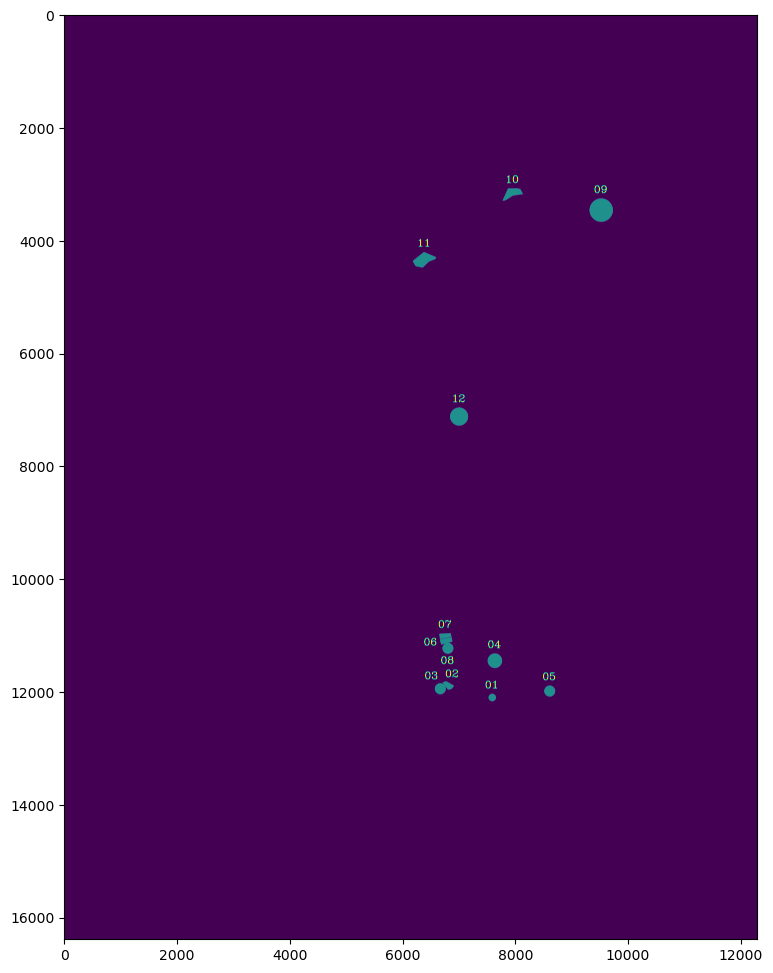

Cell execution time: 8.521 seconds


In [257]:
mask_small = cv2.resize(mask, (mask.shape[1]//4, mask.shape[0]//4),
                         interpolation=cv2.INTER_NEAREST)
fig,ax=plt.subplots(figsize=(12,12))
plt.imshow(mask_small)

In [ ]:
# 1‑eighth resolution
img_small  = cv2.resize(img,   (img.shape[1]//4, img.shape[0]//4),
                         interpolation=cv2.INTER_AREA)
img_small = cv2.cvtColor((img_small * 255).clip(0, 255).astype(np.uint8), cv2.COLOR_RGB2BGR)



In [ ]:
# ensure mask is uint8 0/1
mask_small = (mask_small > 0).astype(np.uint8)

# ---------- OPTION A: PAINT THE PIXELS ----------
overlay = np.zeros_like(img_small, dtype=np.uint8)
overlay[mask_small == 1] = (255, 255, 255)   # colour for the ROI

alpha = 0.5                                  # 0 = transparent, 1 = opaque
blended = cv2.addWeighted(img_small, 1.0,
                          overlay,   alpha, 0)

cv2.imwrite("../plots/ptb211_label.png", blended)